# Section 1. Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

In [2]:
# Hide warning to make the notebook clear.
import warnings
warnings.filterwarnings('ignore')

#### Import libraries and setup matplotlib

In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

In [4]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [5]:
hparams = create_hparams()
hparams.sampling_rate = 22050

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [14]:
#checkpoint_path = "tacotron2_statedict.pt"
#checkpoint_path = "outdir/checkpoint_24000"
checkpoint_path = "outdir/checkpoint_63000"
#checkpoint_path = '/home/sungjaecho/pretrained/tacotron2_statedict.pt'
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [7]:
#waveglow_path = 'waveglow_256channels.pt'
waveglow_path = '/home/sungjaecho/pretrained/waveglow_256channels.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Prepare text input

In [8]:
#text = "Waveglow is really awesome!"
text = "KAIST is a research institute."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

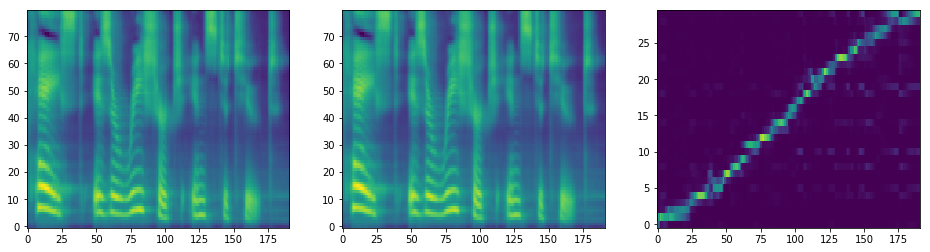

In [15]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [16]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [17]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

# Section 2. Inference with a Single Function

* 32-batch learing
* 12500 training examples
* 390 batches in one epoch
* 390 iterations in one epoch

Then, ...
* 10000 iters = 26 epochs
* 20000 iters = 51 epochs
* 30000 iters = 79 epochs
* 40000 iters = 103 epochs
* 50000 iters =  128 epochs
* 60000 ites = 154 epochs

In [1]:
# Hide warning to make the notebook clear.
import warnings
warnings.filterwarnings('ignore')

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')
        
def show_audio(audio):
    ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)
        
#### Setup hparams
hparams = create_hparams()
hparams.sampling_rate = 22050


class Tacotron2_infering_engine():
    def __init__(self, 
                checkpoint_path='/home/sungjaecho/pretrained/tacotron2_statedict.pt',
                waveglow_path='/home/sungjaecho/pretrained/waveglow_256channels.pt'):
        self.checkpoint_path = None
        self.waveglow_path = None
        self.load_tacotron2(checkpoint_path)
        self.load_waveglow(waveglow_path)
        
    def load_tacotron2(self, checkpoint_path):
        if checkpoint_path == self.checkpoint_path:
            return
        
        #### Load model from checkpoint
        self.model = load_model(hparams)
        self.model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
        _ = self.model.cuda().eval().half()
        
        self.checkpoint_path = checkpoint_path
    
    def load_waveglow(self, waveglow_path):
        if waveglow_path == self.waveglow_path:
            return
        
        #### Load WaveGlow for mel2audio synthesis and denoiser
        self.waveglow = torch.load(waveglow_path)['model']
        self.waveglow.cuda().eval().half()
        for k in self.waveglow.convinv:
            k.float()
        
        self.waveglow_path = waveglow_path
        
    def inference(self, text, with_denoiser=False):
        #### Prepare text input
        sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
        sequence = torch.autograd.Variable(
        torch.from_numpy(sequence)).cuda().long()
        
        #### Decode text input and plot results
        mel_outputs, mel_outputs_postnet, _, alignments = self.model.inference(sequence)
        plot_data((mel_outputs.float().data.cpu().numpy()[0],
                   mel_outputs_postnet.float().data.cpu().numpy()[0],
                   alignments.float().data.cpu().numpy()[0].T))
        
        #### Synthesize audio from spectrogram using WaveGlow
        with torch.no_grad():
            audio = self.waveglow.infer(mel_outputs_postnet, sigma=0.666)
        
        if with_denoiser:
            self.denoiser = Denoiser(self.waveglow)
            audio = self.denoiser(audio, strength=0.01)[:, 0]
        
        return audio
        #ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
t2_infer_engine = Tacotron2_infering_engine()
text="KAIST is a research institute."

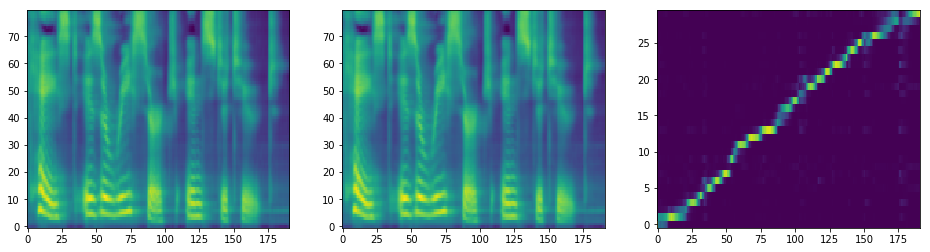

In [3]:
audio = t2_infer_engine.inference(text)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

Warning! Reached max decoder steps


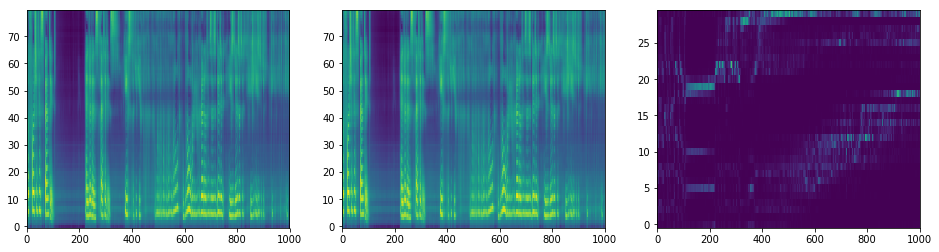

In [5]:
t2_infer_engine.load_tacotron2("outdir/checkpoint_10000")
audio = t2_infer_engine.inference(text)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

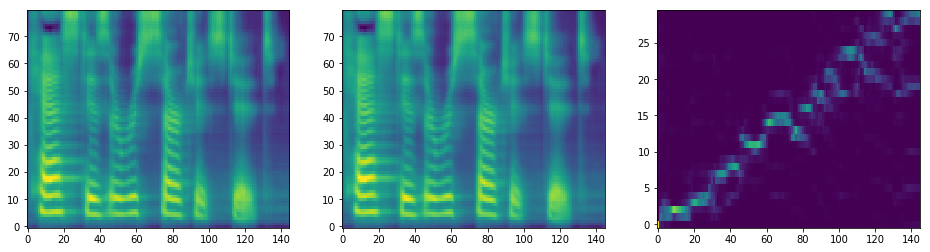

In [6]:
t2_infer_engine.load_tacotron2("outdir/checkpoint_20000")
audio = t2_infer_engine.inference(text)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

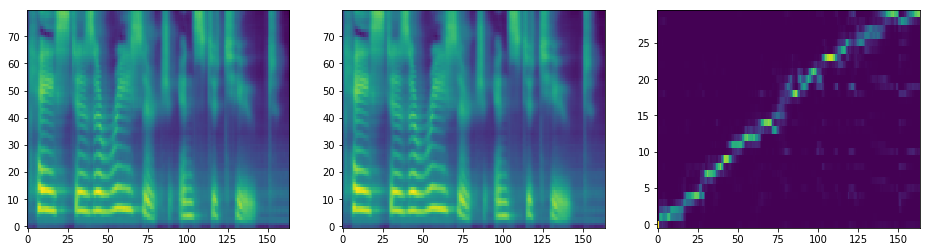

In [7]:
t2_infer_engine.load_tacotron2("outdir/checkpoint_30000")
audio = t2_infer_engine.inference(text)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

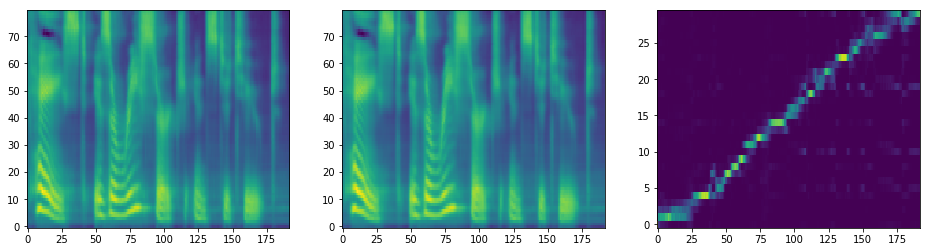

In [8]:
t2_infer_engine.load_tacotron2("outdir/checkpoint_40000")
audio = t2_infer_engine.inference(text)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

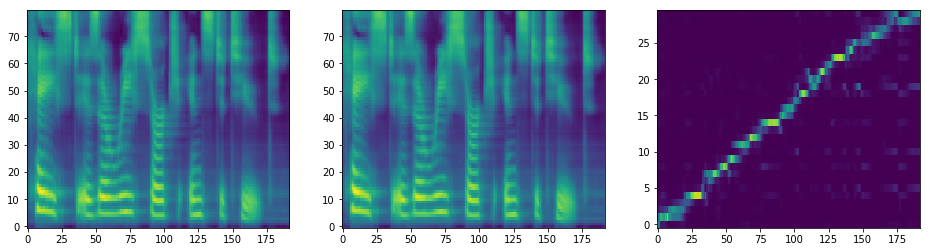

In [9]:
t2_infer_engine.load_tacotron2("outdir/checkpoint_50000")
audio = t2_infer_engine.inference(text)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

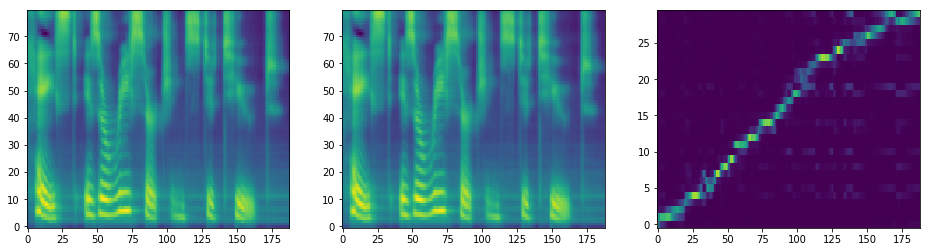

In [10]:
t2_infer_engine.load_tacotron2("outdir/checkpoint_60000")
audio = t2_infer_engine.inference(text)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)